# Project 2: Mini deep-learning framework

You should be able to copy paste everything here to test.py

In [1]:
#!/usr/bin/env python3
""" File to solve the second miniproject which is the design of a framework """

import math
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import empty

__author__ = 'Eugène Lemaitre, Natalie Bolón Brun, Louis Munier'
__version__ = '0.1'

torch.set_grad_enabled(False)

In [2]:
from Linear import Linear
from Activation import Tanh, Relu, Sigmoid
from Loss import LossMSE, CrossEntropy
from Optimizers import Optimizers, Sgd, DecreaseSGD, Adam
from Sequential import Sequential

In [3]:
def compute_number_error(output_one_hot, target_one_hot):
    output = output_one_hot.argmax(dim=1)
    target = target_one_hot.argmax(dim=1)
    nb_of_error = (output != target).sum()
    return nb_of_error

## Data generation

In [4]:
def generate_disc_set(nb):
    X = empty(nb,2).uniform_(0,1)
    Y = empty(X.size())
    
    Y[:,0] = ((X - 0.5).norm(dim=1)  >  math.sqrt(1/(2*math.pi))).type(torch.LongTensor)
    Y[:,1] = ((X - 0.5).norm(dim=1)  <=  math.sqrt(1/(2*math.pi))).type(torch.LongTensor)
    
    return X, Y

def plot_disc(data_in, data_target, title):
    fs = 20
    plt.scatter(data_in[(data_target[:,1]==1),0] ,data_in[(data_target[:,1]==1),1], color = "c", s=20)
    plt.scatter(data_in[(data_target[:,1]==0),0] ,data_in[(data_target[:,1]==0),1], color = "g", s=20)
    plt.title(title, fontsize=fs)
    plt.legend(["1", "0"] )
    plt.show()
    
def plot_result(data_in, data_target, data_class, train=True, fname=None):
    fs = 20
    one_id_as_one = torch.mul( (data_target[:,1]==1), (data_class ==1 ))
    one_id_as_zero = torch.mul( (data_target[:,1]==1), (data_class ==0 ))
    zero_id_as_one = torch.mul( (data_target[:,1]==0), (data_class ==1 ))
    zero_id_as_zero = torch.mul( (data_target[:,1]==0), (data_class ==0 ))
    
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.scatter(data_in[one_id_as_one,0] ,data_in[one_id_as_one,1], color = "c", s=20)
    ax.scatter(data_in[zero_id_as_zero,0] ,data_in[zero_id_as_zero,1], color = "g", s=20)
    ax.scatter(data_in[one_id_as_zero,0] ,data_in[one_id_as_zero,1], color = "r", s=20)
    ax.scatter(data_in[zero_id_as_one,0] ,data_in[zero_id_as_one,1], color = "y", s=20)
    
    if train:
        plt.title("Result on train data", fontsize=fs)
        f_n = '_train_errors'
        
    else:
        plt.title("Result on test data", fontsize=fs)
        f_n = '_test_errors'
    
    plt.legend(["1 id as 1", "0 id as 0", "1 id as 0", "0 id as 1"] )
    
    if isinstance(fname, str):
        fname = fname + f_n
        plt.savefig('output/{}.pdf'.format(fname), bbox_inches='tight')
    
    plt.show()
    
def plot_loss(epochs, loss, fname=None):
    fs = 20
    fig, ax = plt.subplots(1,1, figsize=(10,4))
    ax.plot(epochs, loss)
    ax.set_title("Loss", fontsize=fs)
    ax.set_xlabel("Epoch", fontsize=fs)
    ax.set_ylabel("Loss", fontsize=fs)
    if isinstance(fname, str):
        plt.savefig('output/{}_loss.pdf'.format(fname), bbox_inches='tight')
    plt.show()

In [5]:
Sample_number = 1000
train_input, train_target = generate_disc_set(Sample_number)
test_input, test_target = generate_disc_set(Sample_number)


#plot_disc(train_input, train_target, "Train data before normalization")

mu, std = train_input.mean(0), train_input.std(0)
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

#plot_disc(train_input, train_target, "Train data after normalization")
#plot_disc(test_input, test_target, "Test data after normalization")

tensor([[-1.4063, -0.1148],
        [ 1.2451,  1.1353],
        [ 0.0973,  0.7630],
        ...,
        [ 1.0837, -0.2443],
        [-1.7271, -1.5334],
        [-0.1779,  1.3397]])

## Model 1: No dropout, constant learning rate

In [6]:
hidden_nb = 25
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000

In [7]:


linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_1 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       


my_loss_1 = []

model_1.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_1.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_1.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_1.backward()
        
        optimizer(model_1.sequence)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_1.append(loss_value.item())

0 :  0.6880453824996948
50 :  0.6708303093910217
100 :  0.09831374883651733
150 :  0.05190063267946243
200 :  0.03621215745806694
250 :  0.035541076213121414
300 :  0.03151489049196243
350 :  0.09373290836811066
400 :  0.02104858309030533
450 :  0.14835448563098907
500 :  0.01702575571835041
550 :  0.0178076159209013
600 :  0.019475707784295082
650 :  0.023884886875748634
700 :  0.013510131277143955
750 :  0.012590331956744194
800 :  0.014748535118997097
850 :  0.010615844279527664
900 :  0.017775267362594604
950 :  0.018010864034295082



 
Loss:  0.037473633885383606
Number of errors:  14

 


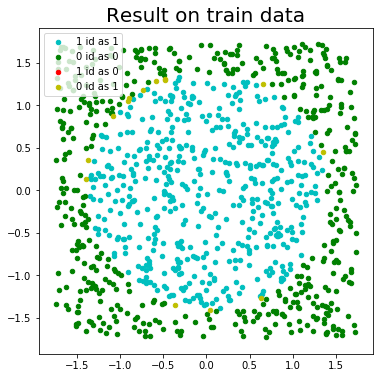

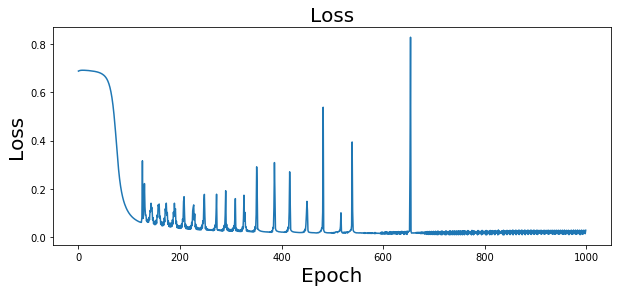

In [28]:
output = model_1.forward(train_input)
l = model_1.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_1)

In [35]:
len(my_loss_1)

1000


 
Loss:  0.08106934279203415
Number of errors:  26

 


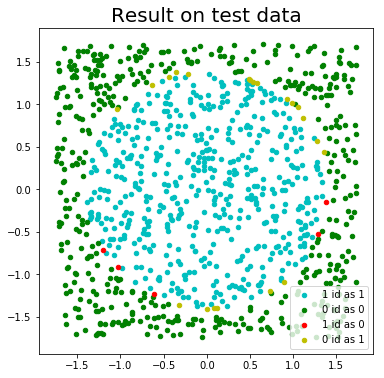

In [33]:
output = model_1.forward(test_input)
l = model_1.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test, train=False, fname='Model1')


## Model 2: No dropout, deacreasing learning rate

In [14]:

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_2 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       
my_loss_2 = []

model_2.normalize_parameters(mean=0, std=std)
optimizer = DecreaseSGD()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_2.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_2.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_2.backward()
        
        optimizer(epochs, model_2.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_2.append(loss_value.item())

0 :  0.6942959427833557
50 :  0.6444471478462219
100 :  0.3800625503063202
150 :  0.18259887397289276
200 :  0.11984634399414062
250 :  0.09286864846944809
300 :  0.07833892852067947
350 :  0.06924926489591599
400 :  0.06277602910995483
450 :  0.05797027423977852
500 :  0.05419830232858658
550 :  0.05114104971289635
600 :  0.04848998785018921
650 :  0.04631439223885536
700 :  0.044520873576402664
750 :  0.04293884336948395
800 :  0.041553955525159836
850 :  0.0403594970703125
900 :  0.039210814982652664
950 :  0.038206785917282104



 
Loss:  0.05148877203464508
Number of errors:  7

 


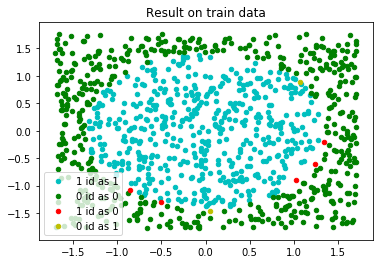

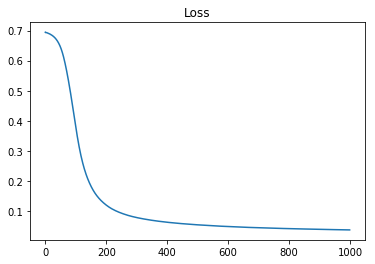

In [15]:
output = model_2.forward(train_input)
l = model_2.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_2)


 
Loss:  0.05187597870826721
Number of errors:  10

 


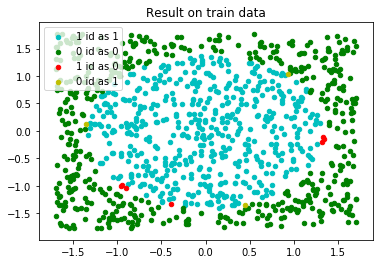

In [16]:
output = model_2.forward(test_input)
l = model_2.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 22: No dropout, Adam optimizer

In [17]:
eta=1e-3
epochs_number_adam = 500

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_22 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 

my_loss_22 = []

model_22.normalize_parameters(mean=0, std=std)

optimizer = Adam(eta, 0.9, 0.99, 1e-8)

for epochs in range(0, epochs_number_adam):
    for b in range(0, Sample_number, batch_size):
        output = model_22.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_22.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_22.backward()
        
        optimizer(model_22.sequence)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_22.append(loss_value.item())

0 :  0.6909273862838745
50 :  0.17028312385082245
100 :  0.04181152209639549
150 :  0.020675964653491974
200 :  0.012692870572209358
250 :  0.008667602203786373
300 :  0.006185302510857582
350 :  0.004657592624425888
400 :  0.0036523437593132257
450 :  0.003043212927877903



 
Loss:  0.005123047158122063
Number of errors:  1

 


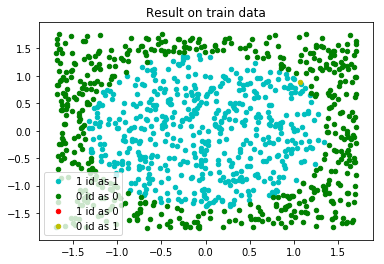

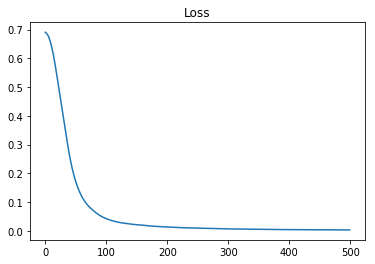

In [18]:
output = model_22.forward(train_input)
l = model_22.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_22)


 
Loss:  0.0102919926866889
Number of errors:  3

 


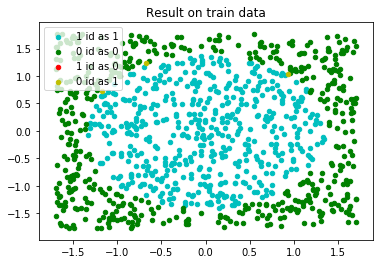

In [19]:
output = model_22.forward(test_input)
l = model_22.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)

## Compare optimizers

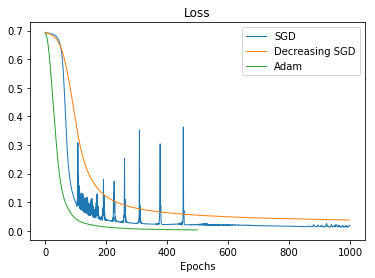

In [24]:
plt.plot(range(0, epochs_number), my_loss_1, linewidth=1)
plt.plot(range(0, epochs_number), my_loss_2, linewidth=1)
plt.plot(range(0, epochs_number_adam), my_loss_22, linewidth=1)
plt.legend(["SGD", "Decreasing SGD", "Adam"])
plt.title("Loss")
plt.xlabel("Epochs")
plt.show()

## Model 3: Dropout, constant learning rate

In [ ]:
dropout = 0.25

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb, dropout=dropout)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb, dropout=dropout)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_3 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       

my_loss_3 = []

model_3.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_3.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_3.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_3.backward()
        
        optimizer(model_3.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_3.append(loss_value.item())

In [ ]:
output = model_3.forward(train_input)
l = model_3.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_3)

In [ ]:
output = model_3.forward(test_input)
l = model_3.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 4: Same as 1 with tanh

In [ ]:

linear_1 = Linear(2, hidden_nb)
relu_1 = Tanh()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Tanh()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Tanh()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_4 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       

my_loss_4 = []

model_4.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_4.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_4.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_4.backward()
        
        optimizer(model_4.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_4.append(loss_value.item())

In [ ]:
output = model_4.forward(train_input)
l = model_4.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_4)

In [ ]:
output = model_4.forward(test_input)
l = model_4.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 4.5 : Same as 1 with tanh and xavier initialization

In [ ]:

linear_1 = Linear(2, hidden_nb)
relu_1 = Tanh()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Tanh()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Tanh()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_45 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       

my_loss_45 = []

model_45.xavier_parameters()
optimizer = Sgd()


for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_45.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_45.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_45.backward()
        
        optimizer(model_45.sequence, eta=eta)
        
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_45.append(loss_value.item())

In [ ]:
output = model_45.forward(train_input)
l = model_45.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_45)

In [ ]:
output = model_45.forward(test_input)
l = model_45.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 5: Same as 1 with Sigmoid

In [ ]:
p_lambda = 0.1

linear_1 = Linear(2, hidden_nb)
relu_1 = Sigmoid(p_lambda)
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Sigmoid(p_lambda)
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Sigmoid(p_lambda)
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_5 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       

my_loss_5 = []

model_5.normalize_parameters(mean=0, std=1)
optimizer = Sgd()


for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_5.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_5.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_5.backward()

        optimizer(model_5.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_5.append(loss_value.item())

In [ ]:
output = model_5.forward(train_input)
l = model_5.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_5)

In [ ]:
output = model_5.forward(test_input)
l = model_5.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 6: Same as 1 but with MSE

In [ ]:

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = LossMSE()

model_6 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       


my_loss_6 = []

model_6.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_6.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_6.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_6.backward()
        
        optimizer(model_6.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_6.append(loss_value.item())

In [ ]:
output = model_6.forward(train_input)
l = model_6.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_6)

In [ ]:
output = model_6.forward(test_input)
l = model_6.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## All graphs

In [ ]:

plt.plot(range(0, epochs_number), my_loss_1, linewidth=1)
plt.plot(range(0, epochs_number), my_loss_2)
plt.plot(range(0, epochs_number), my_loss_3,  linewidth=0.5)
plt.legend(["Base model", "Decreasing sgd", "Dropout"])
plt.title("Loss")
plt.xlabel("Epochs")
plt.show()

plt.plot(range(0, epochs_number), my_loss_1, linewidth=0.5)
plt.plot(range(0, epochs_number), my_loss_4, linewidth=0.5, alpha=0.8)
plt.plot(range(0, epochs_number), my_loss_45, linewidth=0.5, alpha=0.8)
plt.plot(range(0, epochs_number), my_loss_5,  linewidth=0.5)
plt.legend(["Relu", "tanh", "tanh xavier", "sigmoid"])
plt.title("Loss")
plt.xlabel("Epochs")
plt.show()